In [1]:
import cmath
import math

import numpy as np
import qiskit
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from typing import Optional, List, Dict

from qiskit_aws_braket_provider.awsprovider import AWSProvider

In [3]:
def compute_rotation(index_state):

    if len(index_state) != 2:
        return None, None

    index_state = np.asarray(index_state)

    if abs(np.linalg.norm(index_state)) < 1e-6:
        return None, None

    index_state = index_state / np.linalg.norm(index_state)

    if abs(index_state[0] - index_state[1]) < 1e-6:
        return None, None

    a_1 = abs(index_state[0])
    w_1 = cmath.phase(index_state[0])
    a_2 = abs(index_state[1])
    w_2 = cmath.phase(index_state[1])

    alpha_z = w_2 - w_1
    alpha_y = 2 * np.arcsin(abs(a_2) / np.sqrt(a_2 ** 2 + a_1 ** 2))

    return alpha_y, alpha_z

In [4]:
def create_swap_test_circuit(index_state, theta, **kwargs):
    # type: (List[float], float, Optional[dict]) -> QuantumCircuit
    """

    :param index_state:
    :param theta:
    :param kwargs: use_barriers (bool) and readout_swap (Dict[int, int])
    :return:
    """
    use_barriers = kwargs.get('use_barriers', False)
    readout_swap = kwargs.get('readout_swap', None)

    q = qiskit.QuantumRegister(5, "q")
    c = qiskit.ClassicalRegister(2, "c")
    qc = qiskit.QuantumCircuit(q, c, name="improvement")

    # Index on q_0
    alpha_y, _ = compute_rotation(index_state)
    if alpha_y is None:
        qc.h(q[0])
    else:
        qc.ry(-alpha_y, q[0]).inverse()
    if use_barriers: jupyter = qc.barrier()

    # Conditionally exite x_1 on data q_2 (center!)
    qc.h(q[2])
    if use_barriers: qc.barrier()
    qc.rz(math.pi, q[2]).inverse()
    if use_barriers: qc.barrier()
    qc.s(q[2])
    if use_barriers: qc.barrier()
    qc.cz(q[0], q[2])
    if use_barriers: qc.barrier()

    # Label y_1
    qc.cx(q[0], q[1])
    if use_barriers: qc.barrier()

    # Ancilla Superposition
    qc.h(q[4])
    if use_barriers: qc.barrier()

    # Unknown data
    qc.rx(theta, q[3])
    if use_barriers: qc.barrier()

    # c-SWAP!!!
    # standard.barrier(qc)
    qc.cswap(q[4], q[2], q[3])
    if use_barriers: qc.barrier()

    # Hadamard on ancilla q_4
    qc.h(q[4])
    if use_barriers: qc.barrier()

    # Measure on ancilla q_4 and label q_1
    if readout_swap is not None:
        qc.barrier()
        for i in range(q.size):
            j = readout_swap.get(i, i)
            if i != j:
                qc.swap(q[i], q[j])
    else:
        readout_swap = {}

    qc.barrier()
    m1 = readout_swap.get(4, 4)
    m2 = readout_swap.get(1, 1)
    qiskit.circuit.measure.measure(qc, q[m1], c[0])
    qiskit.circuit.measure.measure(qc, q[m2], c[1])

    return qc


In [5]:
def extract_classification(counts: Dict[str, int]) -> float:
    shots = sum(counts.values())
    return (counts.get('00', 0) - counts.get('01', 0) - counts.get('10', 0) + counts.get('11', 0)) / float(shots)

In [6]:

def compare_plot(theta, classification, classification_label=None, compare_classification=None, compare_classification_label=None):
    plt.figure(figsize=(10, 7))
    theta = theta if len(theta) == len(classification) else range(len(classification))

    prefix_label = '{} '.format(classification_label) if classification_label is not None else ''
    plt.scatter(x=[xx for xx, p in zip(theta, classification) if p >= 0],
                y=[p for p in classification if p >= 0],
                label=prefix_label + '$\\tilde{y} = 0$',
                c='red',
                marker='^',
                linewidths=1.0)
    plt.scatter(x=[xx for xx, p in zip(theta, classification) if p < 0],
                y=[p for p in classification if p < 0],
                label=prefix_label + '$\\tilde{y} = 1$',
                c='white',
                marker='^',
                linewidths=1.0, edgecolors='red')
    y_lim_lower = min(classification) - 0.1
    y_lim_upper = max(classification) + 0.1

    if compare_classification is not None and len(compare_classification) == len(classification):
        prefix_label = '{} '.format(compare_classification_label) if compare_classification_label is not None else ''
        plt.scatter(x=[xx for xx, p in zip(theta, compare_classification) if p >= 0],
                    y=[p for p in compare_classification if p >= 0],
                    label=prefix_label + '$\\tilde{y} = 0$',
                    c='blue',
                    marker='s',
                    linewidths=1.0)
        plt.scatter(x=[xx for xx, p in zip(theta, compare_classification) if p < 0],
                    y=[p for p in compare_classification if p < 0],
                    label=prefix_label + '$\\tilde{y} = 1$',
                    c='white',
                    marker='s',
                    linewidths=1.0, edgecolors='blue')
        y_lim_lower = min(min(compare_classification) - 0.1, y_lim_lower)
        y_lim_upper = max(max(compare_classification) + 0.1, y_lim_upper)

    plt.legend(fontsize=17)
    plt.xlabel("$\\theta$ (rad.)", fontsize=22)
    plt.ylabel("$\\langle \\sigma_z^{(a)} \\sigma_z^{(l)} \\rangle$", fontsize=22)
    plt.tick_params(labelsize=22)

    plt.ylim((y_lim_lower, y_lim_upper))

In [7]:
index_state = [np.sqrt(2), np.sqrt(2)]
theta_list = np.arange(start=0, stop=2*np.pi, step=0.2)
qc_list = [create_swap_test_circuit(index_state, theta=theta) for theta in theta_list]
qc_list[0].draw()

┌───┐                               ░       
q_0: ──┤ H ├──────────────────■───■────────░───────
       └───┘                  │ ┌─┴─┐      ░    ┌─┐
q_1: ─────────────────────────┼─┤ X ├──────░────┤M├
       ┌───┐  ┌────────┐┌───┐ │ └───┘      ░    └╥┘
q_2: ──┤ H ├──┤ RZ(pi) ├┤ S ├─■───X────────░─────╫─
     ┌─┴───┴─┐└────────┘└───┘     │        ░     ║ 
q_3: ┤ RX(0) ├────────────────────X────────░─────╫─
     └─┬───┬─┘                    │  ┌───┐ ░ ┌─┐ ║ 
q_4: ──┤ H ├──────────────────────■──┤ H ├─░─┤M├─╫─
       └───┘                         └───┘ ░ └╥┘ ║ 
c: 2/═════════════════════════════════════════╩══╩═
                                              0  1

In [8]:
provider = AWSProvider(region_name='us-east-1')
backend = provider.get_backend('IonQ Device')
sim_backend = provider.get_backend('SV1')

In [9]:
qc_transpiled_list = qiskit.transpile(qc_list, backend)
qobj = qiskit.assemble(qc_transpiled_list, backend, shots=100)

In [10]:
backend.estimate_costs(qobj), sim_backend.estimate_costs(qobj)

(32.0, 40.0)

In [11]:
# ATTENTION!!!!!!
# Uncomment to execute
# BE AWARE that this will create costs!
# ATTENTION!!!!!!

# job = backend.run(qobj, extra_data={
#     'index_state': index_state,
#     'theta_list': list(theta_list)
# })
# job_id = job.job_id()
#
# sim_job = sim_backend.run(qobj, extra_data={
#     'index_state': index_state,
#     'theta_list': list(theta_list)
# })
# sim_job_id = sim_job.job_id()
#
# job_id, sim_job_id

In [18]:
# Please input the job ids here
sim_retrieved_job = sim_backend.retrieve_job('<sim_job_id>')
retrieved_job = backend.retrieve_job('<job_id>')

In [20]:
result = retrieved_job.result()
sim_result = sim_retrieved_job.result()

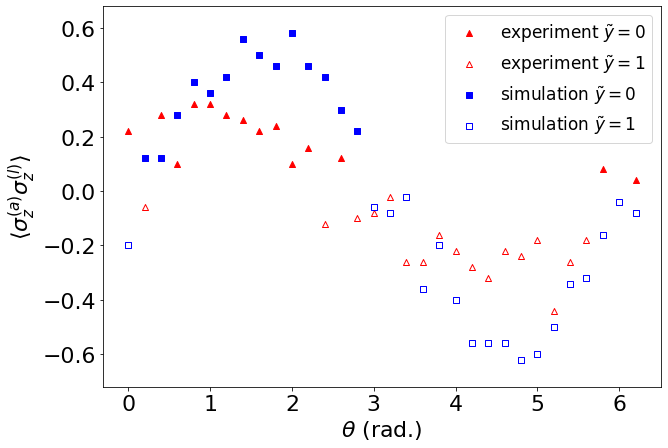

In [21]:

x = retrieved_job.extra_data['theta_list']
experiment_classification = [extract_classification(c) for c in result.get_counts()]
simulation_classification = [extract_classification(c) for c in sim_result.get_counts()]

compare_plot(
    theta=theta_list,
    classification=experiment_classification, classification_label='experiment',
    compare_classification=simulation_classification, compare_classification_label='simulation'
)